# Basic Setup

In [1]:
!pip install pulser

  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 13.1 MB/s eta 0:00:00a 0:00:01
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 10.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━

In [2]:
import numpy as np
import pulser
from matplotlib import pyplot as plt

In [10]:
device = pulser.AnalogDevice
print(device.specs)

A realistic device for analog sequence execution.

Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 80
 - Maximum distance from origin: 38 µm
 - Minimum distance between neighbouring atoms: 5 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 60
 - Ising interaction coefficient: 865723.02
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - SLM Mask: No
 - Maximum sequence duration: 6000 ns
 - Maximum number of runs: 2000

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_

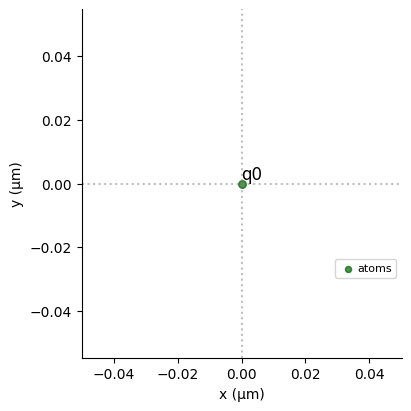

In [11]:
register = pulser.Register.from_coordinates([(0, 0)], prefix="q")
register.draw()

In [12]:
sequence = pulser.Sequence(register, device)

In [13]:
sequence.declare_channel("rydberg_global", "rydberg_global")
print(
    "The states used in the computation are", sequence.get_addressed_states()
)

The states used in the computation are ['r', 'g']


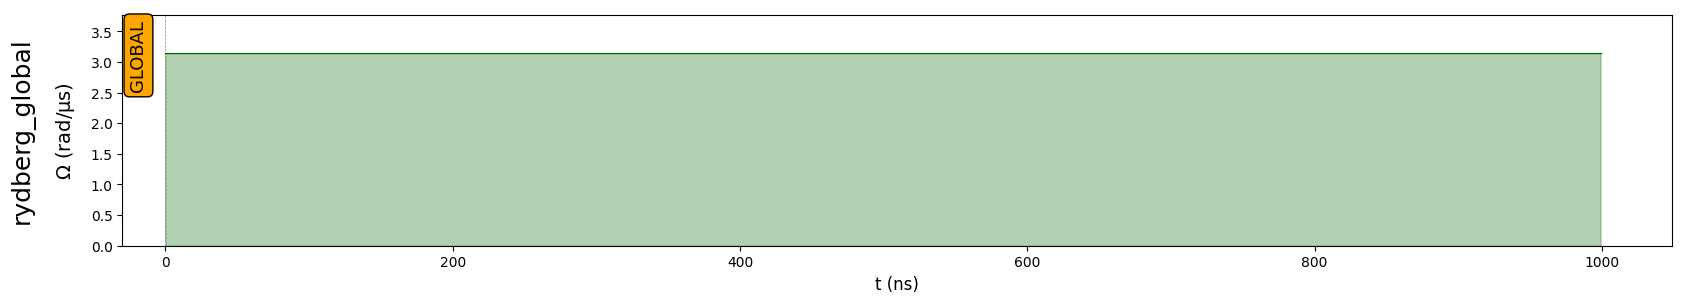

In [14]:
pi_pulse = pulser.Pulse.ConstantPulse(1000, np.pi, 0, 0)
sequence.add(pi_pulse, "rydberg_global")
sequence.draw(mode="input")

In [15]:
backend = pulser.backends.QutipBackend(sequence)
result = backend.run()

In [16]:
result.sample_final_state(1000)

Counter({'1': 1000})

# Ferromagnetic State

In [17]:
# Parameters in rad/µs
U = 2 * np.pi
Omega_max = 2.0 * U
delta_0 = -6 * U
delta_f = 2 * U

# Parameters in ns
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000

In [18]:
device = pulser.AnalogDevice
print(device.specs)

A realistic device for analog sequence execution.

Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 80
 - Maximum distance from origin: 38 µm
 - Minimum distance between neighbouring atoms: 5 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 60
 - Ising interaction coefficient: 865723.02
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - SLM Mask: No
 - Maximum sequence duration: 6000 ns
 - Maximum number of runs: 2000

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_

Interatomic Radius is: 7.186760677748386µm.


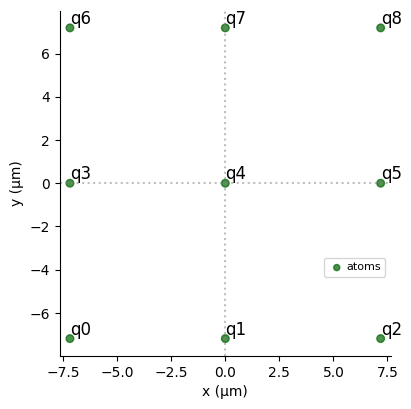

In [19]:
R_interatomic = (device.interaction_coeff / U) ** (1 / 6)
N_side = 3
register = pulser.Register.square(N_side, R_interatomic, prefix="q")
print(f"Interatomic Radius is: {R_interatomic}µm.")
register.draw()

In [20]:
sequence = pulser.Sequence(register, device)

In [21]:
sequence.declare_channel("rydberg_global", "rydberg_global")
print(
    "The states used in the computation are", sequence.get_addressed_states()
)

The states used in the computation are ['r', 'g']


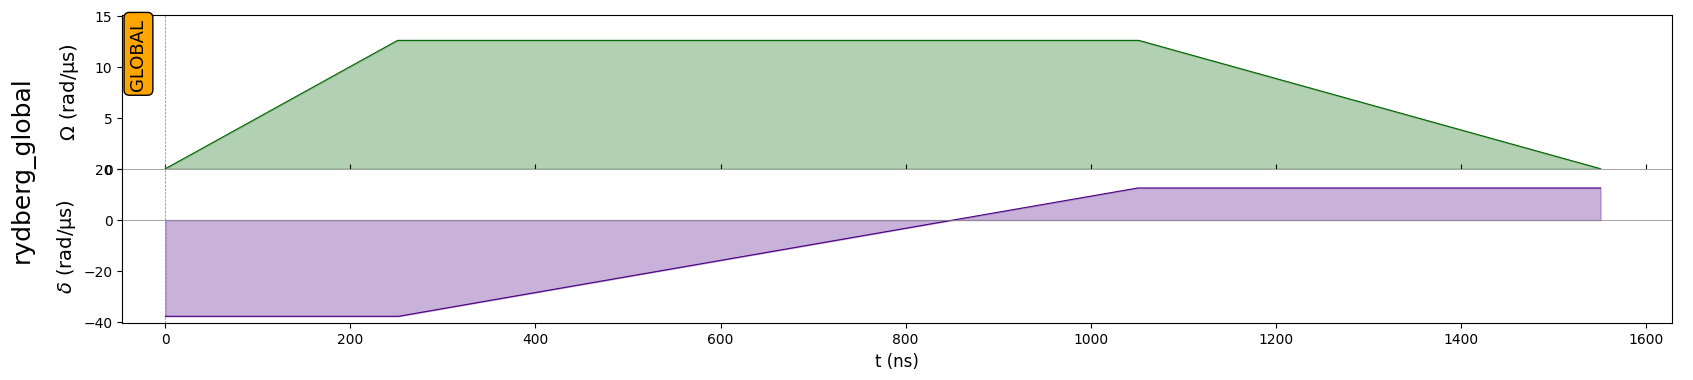

In [22]:
rise = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega_max, pulser.RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)
sequence.add(rise, "rydberg_global")
sequence.add(sweep, "rydberg_global")
sequence.add(fall, "rydberg_global")
sequence.draw(mode="input")


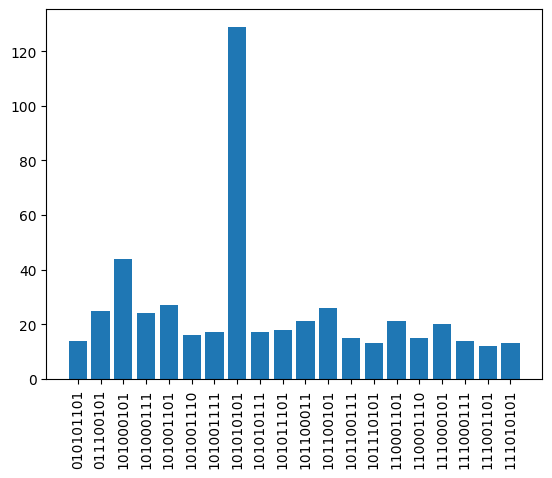

In [23]:
backend = pulser.backends.QutipBackend(sequence)
result = backend.run()
counts = result.sample_final_state(1000)
# Let's plot the histogram associated to the measurements
# Let's select only the states that are measured more than 10 times
most_freq = {k: v for k, v in counts.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()